In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import my_utils as myu

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
# from torch_geometric.nn import SplineConv
from torch_geometric.typing import WITH_TORCH_SPLINE_CONV
from torch_geometric.data import Data

In [2]:
# check for valid spline_conv
if not WITH_TORCH_SPLINE_CONV:
    quit("This example requires 'torch-spline-conv'")

# Check available GPUs and prepare device list
if torch.cuda.is_available():
    devices = [f'cuda:{i}' for i in range(torch.cuda.device_count())]
else:
    devices = ['cpu']  # fallback to CPU if no GPUs are available
print("Using devices:", devices)

Using devices: ['cpu']


Progress: 9.09% - Processed physics_allparticle_000000.vtk
Progress: 18.18% - Processed physics_allparticle_002000.vtk
Progress: 27.27% - Processed physics_allparticle_004000.vtk
Progress: 36.36% - Processed physics_allparticle_006000.vtk
Progress: 45.45% - Processed physics_allparticle_008000.vtk
Progress: 54.55% - Processed physics_allparticle_010000.vtk
Progress: 63.64% - Processed physics_allparticle_012000.vtk
Progress: 72.73% - Processed physics_allparticle_014000.vtk
Progress: 81.82% - Processed physics_allparticle_016000.vtk
Progress: 90.91% - Processed physics_allparticle_018000.vtk
Progress: 100.00% - Processed physics_allparticle_020000.vtk
Interpoalting...
All files processed and interpolated.
Generated 11 data pairs.


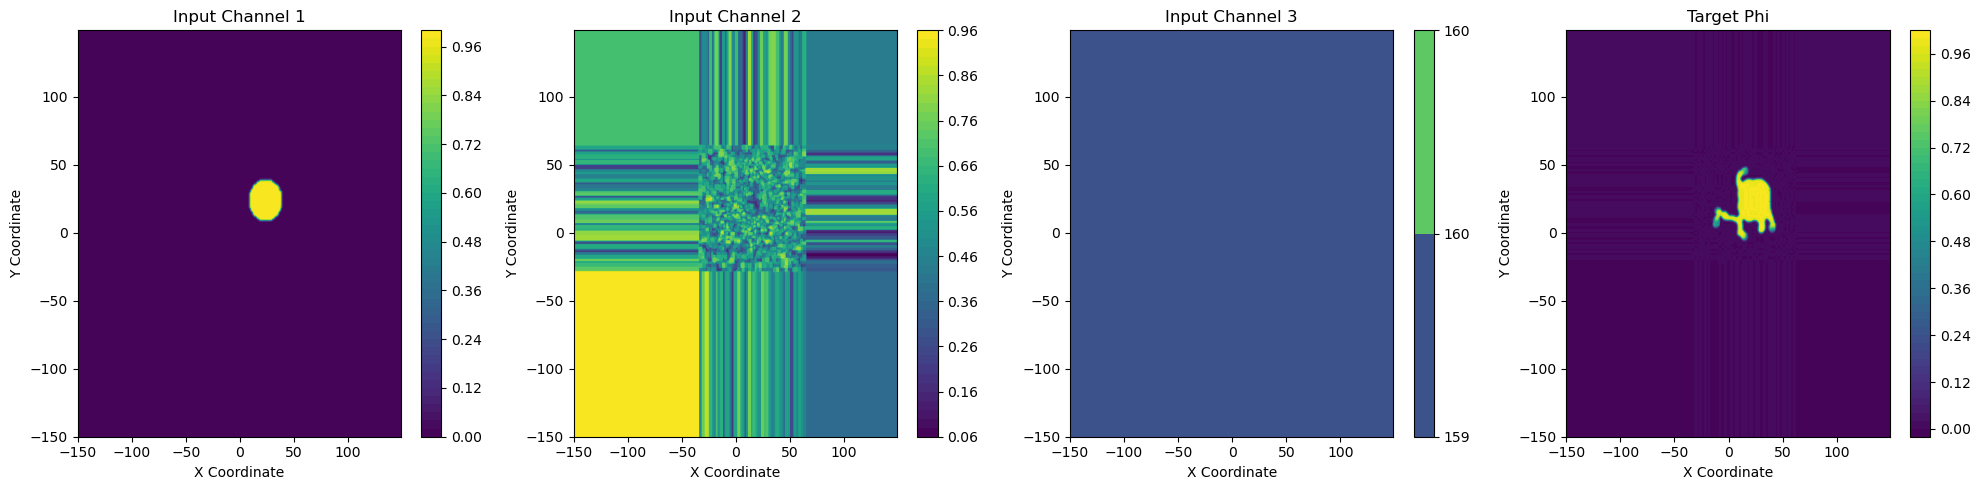

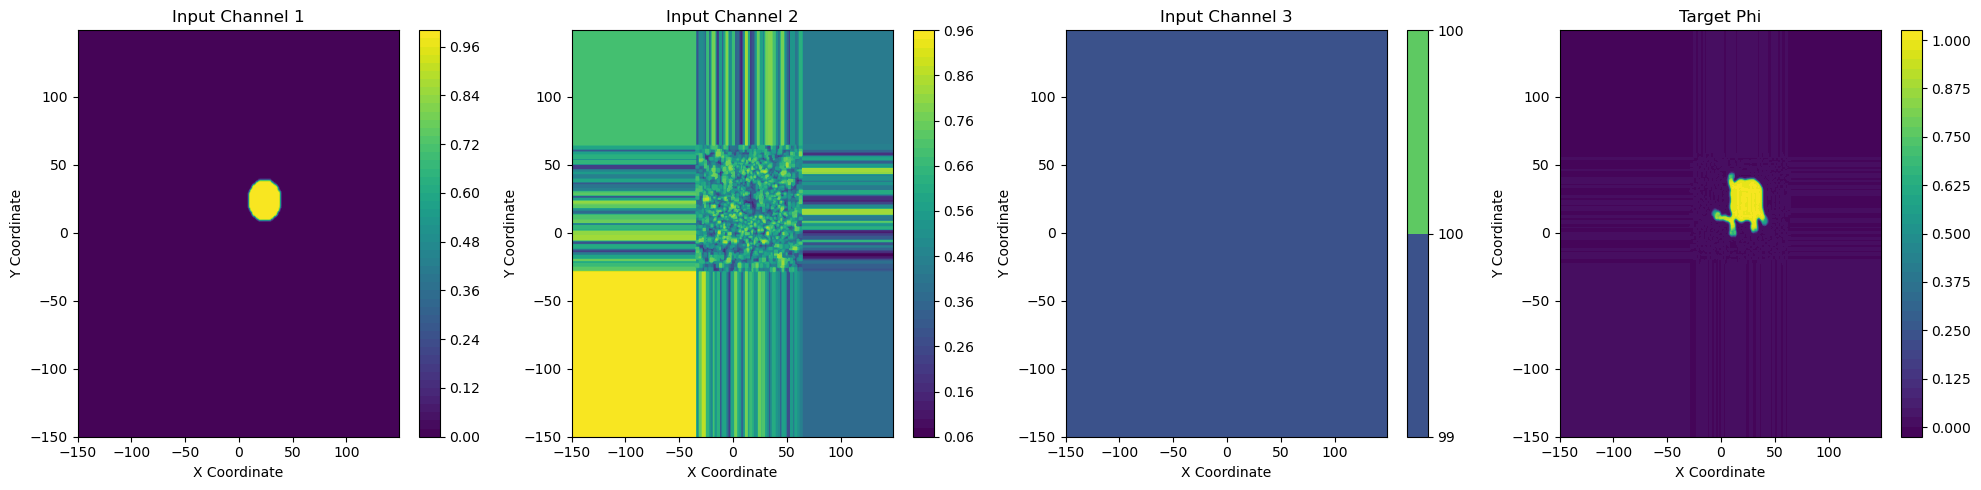

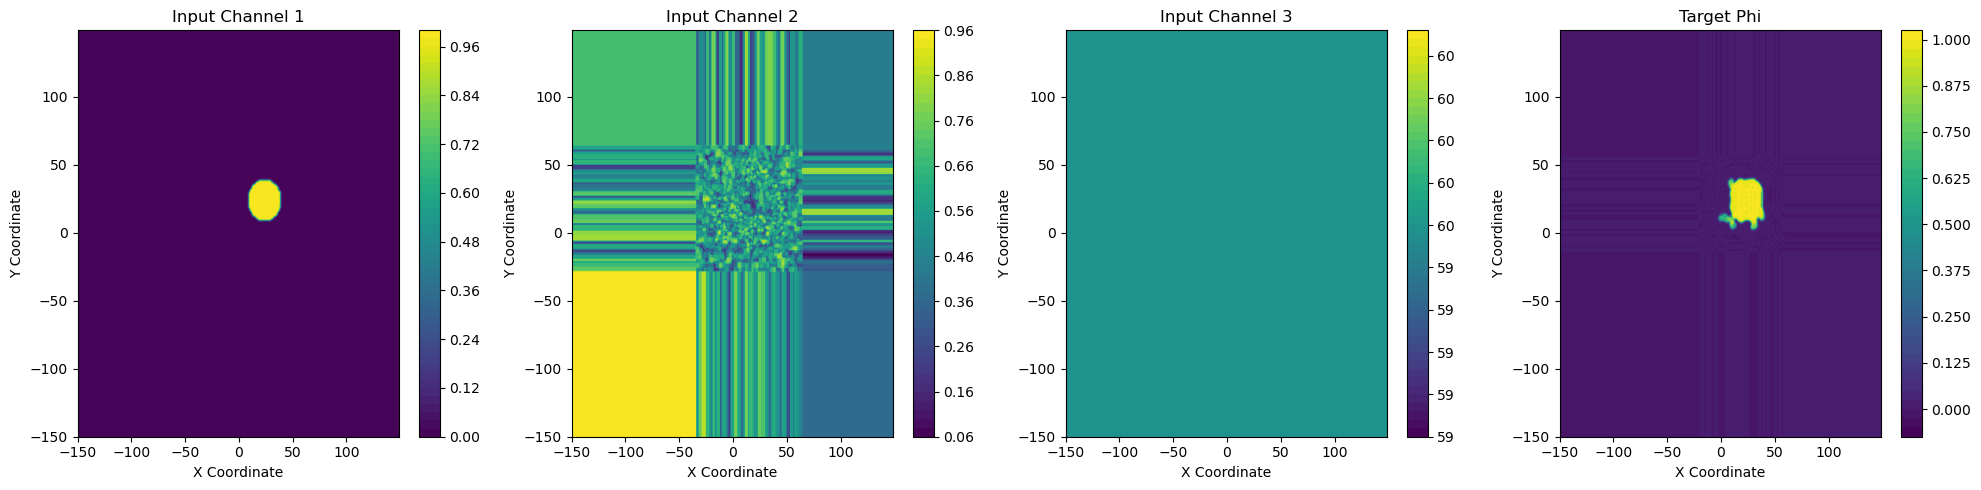

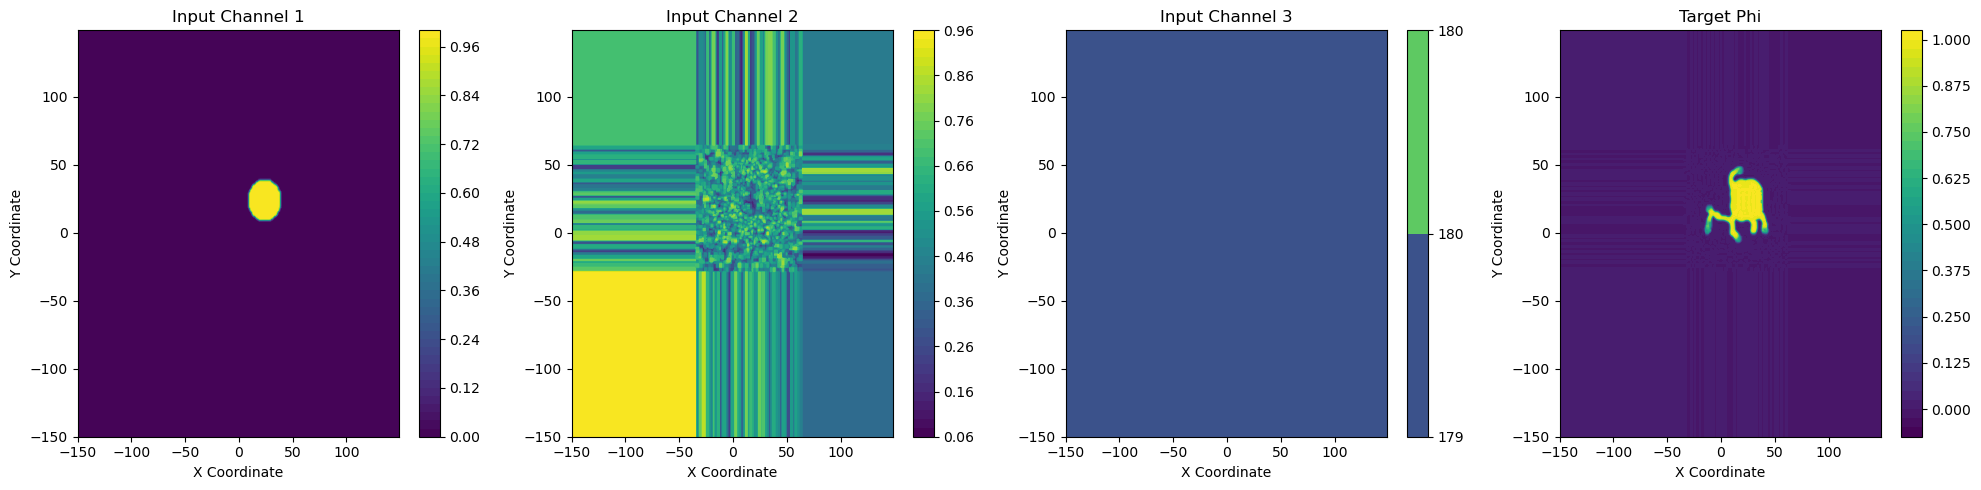

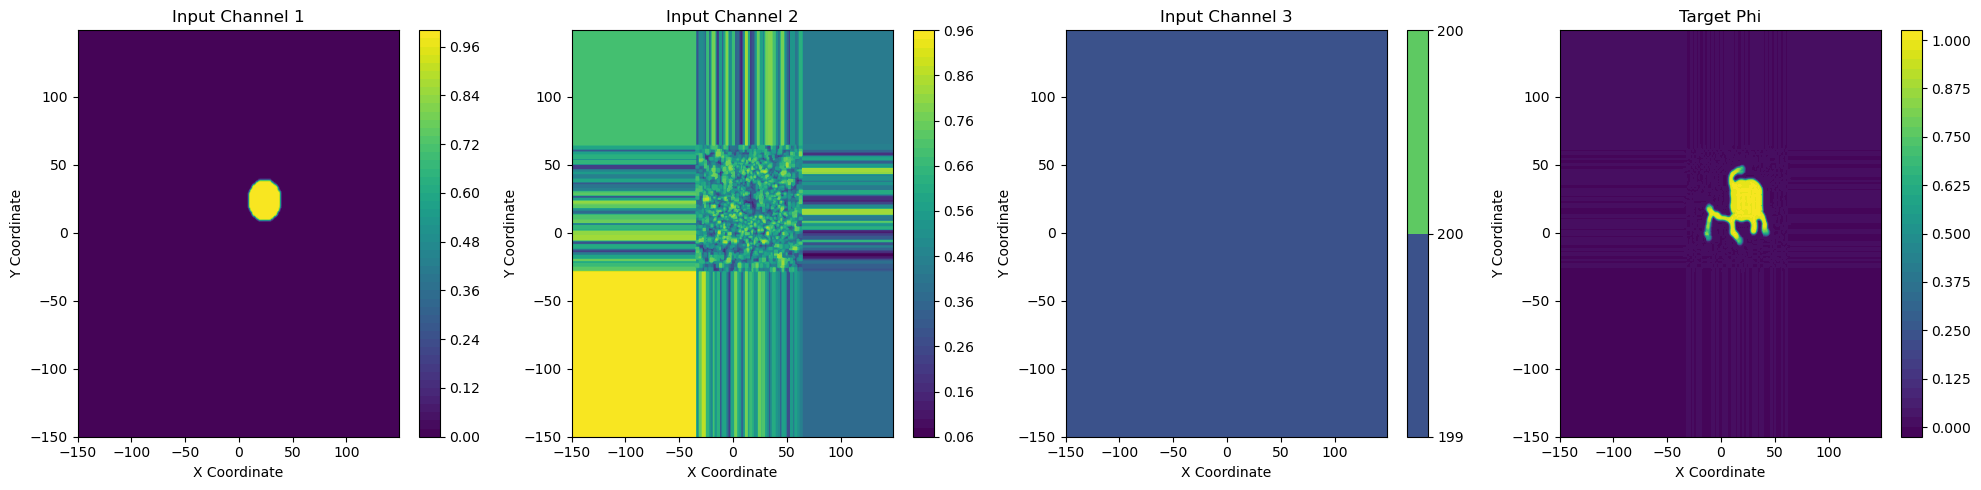

In [3]:
# Data preprocessing into strucutred square matrices for CNN mdoel
folder_path = "./dataset/NDDs/io2D_1c01/outputs" 
# # folder_path = "./dataset/NDD_per1" 
interpolated_data, grid_x, grid_y = myu.read_all_vtks_and_interpolate(folder_path)

if interpolated_data:
    try:
        data_pairs = myu.preprocess_data(interpolated_data)
        print(f"Generated {len(data_pairs)} data pairs.")
        myu.plot_data_pairs(data_pairs, grid_x, grid_y, 5)
    except Exception as e:
        print(f"Error preparing data: {e}")

    # plot_interpolated_data(interpolated_data, grid_x, grid_y)

In [9]:
import h5py
import torch

def save_data_pairs_to_hdf5(data_pairs, hdf5_filename):
    """
    Save data pairs to an HDF5 file with the specified structure.

    Args:
        data_pairs (list): List of tuples, where each tuple contains an input tensor and a target tensor.
        hdf5_filename (str): Name of the HDF5 file to save the data pairs.
    """
    num_samples = len(data_pairs)
    input_shape = data_pairs[0][0].shape  # Should be (3, 300, 300)
    target_shape = (1, *data_pairs[0][1].shape)  # Ensure target shape is (1, 300, 300)

    with h5py.File(hdf5_filename, 'w') as hdf5_file:
        # Create datasets for input data and target data
        data_dataset = hdf5_file.create_dataset('data', shape=(num_samples, *input_shape), dtype='float32')
        target_dataset = hdf5_file.create_dataset('target', shape=(num_samples, *target_shape), dtype='float32')

        for i, (input_tensor, target_tensor) in enumerate(data_pairs):
            # Ensure target tensor has shape (1, 300, 300)
            target_tensor = target_tensor.unsqueeze(0)  # Add channel dimension if not present
            
            # Store the data and target in the HDF5 file
            data_dataset[i] = input_tensor.numpy()
            target_dataset[i] = target_tensor.numpy()

            if i % 100 == 0:
                print(f"Saved {i}/{num_samples} data pairs to HDF5.")

    print(f"All {num_samples} data pairs saved to {hdf5_filename}.")

save_data_pairs_to_hdf5(data_pairs, './dataset/dataset.hdf5')


Saved 0/11 data pairs to HDF5.
All 11 data pairs saved to ./dataset/dataset.hdf5.


In [ ]:
def print_data_pairs_info(data_pairs):
    """
    Prints the shapes and types of elements within each data pair.
    
    Args:
        data_pairs (list): A list of tuples, where each tuple contains tensors 
                           (input_tensor, target_tensor).
    """
    for idx, (input_tensor, target_tensor) in enumerate(data_pairs):
        print(f"Data pair {idx + 1}:")
        print(f"  Input Tensor: Shape = {input_tensor.shape}, Type = {type(input_tensor)}")
        print(f"  Target Tensor: Shape = {target_tensor.shape}, Type = {type(target_tensor)}")


print(len(data_pairs))
print_data_pairs_info(data_pairs)

11
Data pair 1:
  Input Tensor: Shape = torch.Size([3, 103, 103]), Type = <class 'torch.Tensor'>
  Target Tensor: Shape = torch.Size([103, 103]), Type = <class 'torch.Tensor'>
Data pair 2:
  Input Tensor: Shape = torch.Size([3, 103, 103]), Type = <class 'torch.Tensor'>
  Target Tensor: Shape = torch.Size([103, 103]), Type = <class 'torch.Tensor'>
Data pair 3:
  Input Tensor: Shape = torch.Size([3, 103, 103]), Type = <class 'torch.Tensor'>
  Target Tensor: Shape = torch.Size([103, 103]), Type = <class 'torch.Tensor'>
Data pair 4:
  Input Tensor: Shape = torch.Size([3, 103, 103]), Type = <class 'torch.Tensor'>
  Target Tensor: Shape = torch.Size([103, 103]), Type = <class 'torch.Tensor'>
Data pair 5:
  Input Tensor: Shape = torch.Size([3, 103, 103]), Type = <class 'torch.Tensor'>
  Target Tensor: Shape = torch.Size([103, 103]), Type = <class 'torch.Tensor'>
Data pair 6:
  Input Tensor: Shape = torch.Size([3, 103, 103]), Type = <class 'torch.Tensor'>
  Target Tensor: Shape = torch.Size([1

In [ ]:
import torch.optim as optim


# Calculate the number of samples
num_samples = len(data_pairs)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1  # Note: Make sure these ratios sum to 1.0

# Compute split indices
num_train = int(num_samples * train_ratio)
num_val = int(num_samples * val_ratio)
num_test = num_samples - num_train - num_val

# Randomly shuffle indices
indices = torch.randperm(num_samples)

# Split indices for each dataset
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train + num_val]
test_indices = indices[num_train + num_val:]

# Extract splits
train_data = [data_pairs[i] for i in train_indices]
val_data = [data_pairs[i] for i in val_indices]
test_data = [data_pairs[i] for i in test_indices]

# Initialize the model, optimizer, and loss function
from NeuralNetworks import ConvolutionalAutoencoder
model = ConvolutionalAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

model(train_data[0][0])
# # Training loop
# for epoch in range(101):  # Number of epochs
#     model.train()
#     total_loss = 0
#     for input_tensor, target_tensor in train_data:
#         input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
#         target_tensor = target_tensor.unsqueeze(0)  # Add batch dimension
#         optimizer.zero_grad()
#         outputs = model(input_tensor)
#         loss = criterion(outputs, target_tensor)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_data)}")

#     # Validation step
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for input_tensor, target_tensor in val_data:
#             input_tensor = input_tensor.unsqueeze(0)
#             target_tensor = target_tensor.unsqueeze(0)
#             outputs = model(input_tensor)
#             loss = criterion(outputs, target_tensor)
#             val_loss += loss.item()
#     print(f"Epoch {epoch + 1}, Validation Loss: {val_loss / len(val_data)}")

After conv1 and pool: torch.Size([84, 51, 51])
After conv2 and pool: torch.Size([168, 25, 25])
After conv3 and pool: torch.Size([336, 12, 12])
After t_conv1: torch.Size([336, 12, 12])
After t_conv2: torch.Size([168, 24, 24])
After t_conv3: torch.Size([84, 48, 48])
Final output: torch.Size([1, 96, 96])


tensor([[[0.5118, 0.5655, 0.4532,  ..., 0.3963, 0.5495, 0.4399],
         [0.4351, 0.7792, 0.7885,  ..., 0.3096, 0.5203, 0.5922],
         [0.3566, 0.6929, 0.2880,  ..., 0.5281, 0.3989, 0.6952],
         ...,
         [0.5142, 0.5615, 0.5350,  ..., 0.3863, 0.3611, 0.4036],
         [0.4345, 0.5095, 0.3553,  ..., 0.5418, 0.3417, 0.4171],
         [0.5537, 0.6503, 0.3084,  ..., 0.5786, 0.5006, 0.4644]]],
       grad_fn=<SigmoidBackward0>)

In [ ]:
train_data[0][0]

tensor([[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[  0.9500,   0.9500,   0.4883,  ...,   0.4542,   0.3600,   0.3600],
         [  0.9500,   0.9500,   0.4883,  ...,   0.4542,   0.3600,   0.3600],
         [  0.9500,   0.9500,   0.4883,  ...,   0.4542,   0.3600,   0.3600],
         ...,
         [  0.5817,   0.5817,   0.6101,  ...,   0.5680,   0.4525,   0.4525],
         [  0.6800,   0.6800,   0.2825,  ...,   0.6392,   0.4400,   0.4400],
         [  0.6800,   0.6800,   0.2825,  ...,   0.6392,   0.4400,   0.4400]],

        [[120.0000, 120.0000, 120.0000,  ...

In [ ]:
# Plot the convergence of training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, len(test_acc_list) + 1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convergence Plot')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
@torch.no_grad()
def evaluate_model_regression(data, model):
    model.eval()
    out = model(data)
    
    actual = data.y[data.test_mask]
    print(actual.size())
    
    # # Calculate Mean Squared Error
    # mse = F.mse_loss(out[data.test_mask], actual)
    # print(f'Test MSE: {mse.item():.4f}')

    # Ensure output is within the [0, 1] range using sigmoid (if not already applied in the model)
    out_prob = torch.sigmoid(out[data.test_mask]).squeeze()  # Apply sigmoid to ensure the outputs are probabilities.
    # Calculate Binary Cross-Entropy
    bce = F.binary_cross_entropy(out_prob, actual)
    print(f'Test BCE: {bce.item():.4f}')

    # Print sample predictions for checking
    print("\nSample Predictions:")
    num_samples = min(10, out[data.test_mask].size(0))
    for i in range(num_samples):
        print(f'Predicted: {out[data.test_mask][i].item():.4f}, Actual: {actual[i].item():.4f}')

evaluate_model_regression(data, model)

In [ ]:
@torch.no_grad()
def evaluate_model_regression(data, model):
    model.eval()
    out = model(data)
    
    actual = data.y[data.test_mask]
    print(actual.size())
    
    # Ensure output is within the [0, 1] range using sigmoid (if not already applied in the model)
    out_prob = torch.sigmoid(out[data.test_mask]).squeeze()  # Apply sigmoid to ensure the outputs are probabilities.
    
    # Calculate Binary Cross-Entropy
    bce = F.binary_cross_entropy(out_prob, actual)
    print(f'Test BCE: {bce.item():.4f}')

    # Calculate accuracy for the entire test dataset
    # predicted_labels = (out_prob > 0.7).int()  # Apply threshold to convert probabilities to binary labels
    predicted_labels = out_prob  # Apply threshold to convert probabilities to binary labels
    correct_predictions = (predicted_labels == actual).float().sum().item()  # Calculate the number of correct predictions
    total_predictions = actual.size(0)  # Total number of predictions
    accuracy = correct_predictions / total_predictions  # Calculate accuracy
    print(f'Test Accuracy: {accuracy:.4f}')

    # Print sample predictions for checking
    print("\nSample Predictions:")
    num_samples = min(20, actual.size(0))  # Limit number of samples to print
    if num_samples > 0:
        sample_indices = torch.randperm(actual.size(0))[:num_samples]  # Randomly pick indices to print
        for i in sample_indices:
            predicted_label = predicted_labels[i].item()
            out_prob_val = out_prob[i].item()
            actual_val = actual[i].item()
            print(f'Pred label: {predicted_label}, Out prob: {out_prob_val:.4f}, Actual: {actual_val:.0f}')

    plt.hist(out_prob.detach().cpu().numpy(), bins=50)
    plt.title('Histogram of Model Output Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

evaluate_model_regression(data, model)

In [ ]:
@torch.no_grad()
def evaluate_model(data, model, rotation_angle_degrees=-45, num_samples=100):
    model.eval()
    out = model(data)
    
    # Get all test indices
    test_indices = torch.where(data.test_mask)[0]
    
    # Randomly sample from the test indices if the number is greater than num_samples
    if len(test_indices) > num_samples:
        sampled_indices = test_indices[torch.randperm(len(test_indices))[:num_samples]]
    else:
        sampled_indices = test_indices

    # out_prob = torch.sigmoid(out[sampled_indices].squeeze())  # Apply sigmoid to ensure the outputs are probabilities
    # threshold = 0.7  # Define the threshold
    # pred = (out_prob > threshold).int()  # Convert probabilities to binary labels based on the threshold
    pred = torch.sigmoid(out[sampled_indices].squeeze())
    actual = data.y[sampled_indices]
    input_phi = data.x[sampled_indices, 2]  # Assuming the third column is phi
    error = (pred - actual).abs()  # Calculate error as absolute difference

    # # Calculate accuracy for the sampled cases
    # correct = pred.round().eq(actual.round()).sum().item()
    # total = len(sampled_indices)
    # accuracy = correct / total
    # print(f'Test Accuracy (sampled): {accuracy:.4f} for {num_samples} samples')

    # Reverse the rotation for visualization purposes
    angle = np.radians(rotation_angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
    ])

    coords = data.x[sampled_indices][:, :2].cpu().numpy()  # Ensure the first two columns are coordinates
    new_coords = np.dot(coords, rotation_matrix)

    # Visualization of 2D predictions
    fig, ax = plt.subplots(1, 4, figsize=(28, 7), sharex=True, sharey=True)
    scatter = ax[0].scatter(new_coords[:, 0], new_coords[:, 1], c=input_phi.cpu().numpy(), cmap='viridis', s=50)
    ax[0].set_title('Input Phi')
    ax[0].set_xlabel('X Coordinate')
    ax[0].set_ylabel('Y Coordinate')
    plt.colorbar(scatter, ax=ax[0], label='Input Phi Value')

    scatter = ax[1].scatter(new_coords[:, 0], new_coords[:, 1], c=pred.cpu().numpy(), cmap='viridis', s=50)
    ax[1].set_title('Predicted Phi')
    ax[1].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[1], label='Predicted Class')

    scatter = ax[2].scatter(new_coords[:, 0], new_coords[:, 1], c=actual.cpu().numpy(), cmap='viridis', s=50)
    ax[2].set_title('Actual Phi')
    ax[2].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[2], label='Actual Class')

    # Error visualization
    scatter = ax[3].scatter(new_coords[:, 0], new_coords[:, 1], c=error.cpu().numpy(), cmap='viridis', s=50)
    ax[3].set_title('Absolute error')
    ax[3].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[3], label='Error')

    plt.show()

evaluate_model(data, model, 0, num_samples=1000)

In [ ]:
# # credits:
# # how to use DDP module with DDP sampler: https://gist.github.com/sgraaf/5b0caa3a320f28c27c12b5efeb35aa4c
# # how to setup a basic DDP example from scratch: https://pytorch.org/tutorials/intermediate/dist_tuto.html
# import os
# import torch
# import torch.distributed as dist
# import torch.multiprocessing as mp
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torchvision import datasets, transforms
# import random

# from torch.nn.parallel import DistributedDataParallel as DDP

# from torch.utils.data import DataLoader, Dataset
# from torch.utils.data.distributed import DistributedSampler
# import math

# def get_dataset():
#     world_size = dist.get_world_size()
#     train_set = datasets.MNIST('./data', train=True, download=True,
#                              transform=transforms.Compose([
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((0.1307,), (0.3081,))
#                              ]))
#     val_set = datasets.MNIST('./data', train=False, download=True,
#                              transform=transforms.Compose([
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((0.1307,), (0.3081,))
#                              ]))
    
#     train_sampler = DistributedSampler(train_set,num_replicas=world_size)
#     val_sampler = DistributedSampler(val_set,num_replicas=world_size)
#     batch_size = int(128 / float(world_size))
#     print(world_size, batch_size)
#     train_loader = DataLoader(
#         dataset=train_set,
#         sampler=train_sampler,
#         batch_size=batch_size
#     )
#     val_loader = DataLoader(
#         dataset=val_set,
#         sampler=val_sampler,
#         batch_size=batch_size
#     )

#     return train_loader, val_loader, batch_size
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x
# def average_gradients(model):
#     size = float(dist.get_world_size())
#     for param in model.parameters():
#         dist.all_reduce(param.grad.data, op=dist.ReduceOp.SUM)
#         param.grad.data /= size
# def reduce_dict(input_dict, average=True):
#     world_size = float(dist.get_world_size())
#     names, values = [], []
#     for k in sorted(input_dict.keys()):
#         names.append(k)
#         values.append(input_dict[k])
#     values = torch.stack(values, dim=0)
#     dist.all_reduce(values, op=dist.ReduceOp.SUM)
#     if average:
#         values /= world_size
#     reduced_dict = {k: v for k, v in zip(names, values)}
#     return reduced_dict
# def train(model,train_loader,optimizer,batch_size):
#     device = torch.device(f"cuda:{dist.get_rank()}")
#     train_num_batches = int(math.ceil(len(train_loader.dataset) / float(batch_size)))
#     model.train()
#     # let all processes sync up before starting with a new epoch of training
#     # dist.barrier()
#     criterion = nn.CrossEntropyLoss().to(device)
#     train_loss = 0.0
#     for data, target in train_loader:
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         # average gradient as DDP doesn't do it correctly
#         average_gradients(model)
#         optimizer.step()
#         loss_ = {'loss': torch.tensor(loss.item()).to(device)}
#         train_loss += reduce_dict(loss_)['loss'].item()
#         # cleanup
#         # dist.barrier()
#         # data, target, output = data.cpu(), target.cpu(), output.cpu()
#     train_loss_val = train_loss / train_num_batches
#     return train_loss_val
# def accuracy(output, target, topk=(1,)):
#     """Computes the accuracy over the k top predictions for the specified values of k"""
#     with torch.no_grad():
#         maxk = max(topk)
#         batch_size = target.size(0)

#         _, pred = output.topk(maxk, 1, True, True)
#         pred = pred.t()
#         correct = pred.eq(target.view(1, -1).expand_as(pred))

#         res = []
#         for k in topk:
#             correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
#             res.append(correct_k.div_(batch_size))
#         return res
# def val(model, val_loader,batch_size):
#     device = torch.device(f"cuda:{dist.get_rank()}")
#     val_num_batches = int(math.ceil(len(val_loader.dataset) / float(batch_size)))
#     model.eval()
#     # let all processes sync up before starting with a new epoch of training
#     # dist.barrier()
#     criterion = nn.CrossEntropyLoss().to(device)
#     val_loss = 0.0
#     with torch.no_grad():
#         for data, target in val_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             loss = criterion(output, target)
#             loss_ = {'loss': torch.tensor(loss.item()).to(device)}
#             val_loss += reduce_dict(loss_)['loss'].item()
#     val_loss_val = val_loss / val_num_batches
#     return val_loss_val
# def run(rank, world_size):
#     torch.cuda.set_device(rank)
#     torch.cuda.empty_cache()
#     device = torch.device(f"cuda:{rank}")
#     torch.manual_seed(1234)
#     train_loader, val_loader, batch_size = get_dataset()
#     model = Net().to(device)
#     model = nn.SyncBatchNorm.convert_sync_batchnorm(model) # use if model contains batchnorm.
#     model = DDP(model,device_ids=[rank],output_device=rank)
#     optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5)
#     history =  {
#             "rank": rank,
#             "train_loss_val": [],
#             "train_acc_val": [],
#             "val_loss_val": [],
#             "val_acc_val": []
#         }
#     if rank == 0:
#         history = {
#             "rank": rank,
#             "train_loss_val": [],
#             "train_acc_val": [],
#             "val_loss_val": [],
#             "val_acc_val": []
#         }
#     for epoch in range(10):
#         train_loss_val = train(model,train_loader,optimizer,batch_size)
#         val_loss_val = val(model,val_loader,batch_size)
#         if rank == 0:
#             print(f'Rank {rank} epoch {epoch}: {train_loss_val:.2f}/{val_loss_val:.2f}')
#             history['train_loss_val'].append(train_loss_val)
#             history['val_loss_val'].append(val_loss_val)
#     print(f'Rank {rank} finished training')
#     print(history)
#     cleanup(rank)  

# def cleanup(rank):
#     # dist.cleanup()  
#     dist.destroy_process_group()
#     print(f"Rank {rank} is done.")
# def setup_for_distributed(is_master):
#     """
#     This function disables printing when not in master process
#     """
#     import builtins as __builtin__
#     builtin_print = __builtin__.print

#     def print(*args, **kwargs):
#         force = kwargs.pop('force', False)
#         if is_master or force:
#             builtin_print(*args, **kwargs)

#     __builtin__.print = print
# def init_process(
#         rank, # rank of the process
#         world_size, # number of workers
#         fn, # function to be run
#         # backend='gloo',# good for single node
#         # backend='nccl' # the best for CUDA
#         backend='gloo'
#     ):
#     # information used for rank 0
#     os.environ['MASTER_ADDR'] = '127.0.0.1'
#     os.environ['MASTER_PORT'] = '29500'
#     dist.init_process_group(backend, rank=rank, world_size=world_size)
#     dist.barrier()
#     setup_for_distributed(rank == 0)
#     fn(rank, world_size)


# if __name__ == "__main__":
#     world_size = 2
#     processes = []
#     mp.set_start_method("spawn")
#     for rank in range(world_size):
#         p = mp.Process(target=init_process, args=(rank, world_size, run))
#         p.start()
#         processes.append(p)

#     for p in processes:
#         p.join()